<a href="https://colab.research.google.com/github/anysharaju/EEG-BCI-Robotic-Hand-Control/blob/main/Copy_of_Human_Computer_Interaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os
import pandas as pd
import numpy as np
from scipy.signal import welch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Path to your zip file
zip_path = "/content/drive/MyDrive/dataset/BCICIV_2a_csv.zip"
# Extract location
extract_to = "/content/bci_data"

# Create directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Check files
csv_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(extract_to)
             for f in filenames if f.endswith('.csv')]
print("Found CSV files:", csv_files)


Found CSV files: ['/content/bci_data/BCICIV_2a_all_patients.csv', '/content/bci_data/patients/patients/BCICIV_2a_9.csv', '/content/bci_data/patients/patients/BCICIV_2a_1.csv', '/content/bci_data/patients/patients/BCICIV_2a_7.csv', '/content/bci_data/patients/patients/BCICIV_2a_8.csv', '/content/bci_data/patients/patients/BCICIV_2a_5.csv', '/content/bci_data/patients/patients/BCICIV_2a_2.csv', '/content/bci_data/patients/patients/BCICIV_2a_3.csv', '/content/bci_data/patients/patients/BCICIV_2a_4.csv', '/content/bci_data/patients/patients/BCICIV_2a_6.csv']


In [ ]:
# Load all CSV files into a single DataFrame
data_frames = []
for file in csv_files:
    df = pd.read_csv(file)
    data_frames.append(df)

# Concatenate all DataFrames into one
data = pd.concat(data_frames, ignore_index=True)

# Display the first few rows of the data
print("Original data shape:", data.shape)
print(data.head())

# Check unique values in the 'label' column
print("\nUnique labels in dataset:", data['label'].unique())

Original data shape: (984096, 26)
   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1        1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2        1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3        1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4        1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   

      EEG-3     EEG-4  ...     EEG-8     EEG-9    EEG-10    EEG-11    EEG-12  \
0 -1.523659 -0.575267  ...  0.758116  3.441785  0.305517  1.137473 -1.275763   
1  1.505904  0.891796  ...  1.541586 -0.071620  0.258909 -1.448198  0.142472   
2  2.613414  4.636026  ...  2.649097 -2.137938 -1.612096 -1.610218 -0.410173   
3  5.995872  6.651295  ...  6.031554 -5.249621 -2.672998 -3.452370  0.189081   
4  4.519931  6.249573  ...  7.827097 -5.309546 -2.488783 -3.707608  1.447515   

     EEG-13    EEG-14    EEG

In [ ]:
# ----------- FILTER MOTOR IMAGERY PART ONLY ----------- #
# Define motor imagery labels
motor_labels = ['left', 'right', 'foot', 'tongue']

# If the label format is numeric (0, 1, 2, 3) instead of text, we need to map them
label_map = {0: 'left', 1: 'right', 2: 'foot', 3: 'tongue'}
if all(isinstance(label, (int, np.integer)) for label in data['label'].unique()):
    data['label'] = data['label'].map(label_map)

# Fix: Check if filtering works with the actual labels in your dataset
print("\nSample of labels:", data['label'].head(20))
print("Time range in dataset:", data['time'].min(), "to", data['time'].max())

# Try both ways of filtering based on the dataset structure
try:
    # Proper filtering by label AND time window (2s-6s)
    motor_imagery_data = data[
        (data['label'].isin(motor_labels)) &
        (data['time'] >= 2) & (data['time'] <= 6)
    ]

    if motor_imagery_data.empty:
        # Alternative: Try if the labels are different or time is in a different format
        # Try with numeric labels
        numeric_labels = [0, 1, 2, 3]
        motor_imagery_data = data[
            (data['label'].isin(numeric_labels)) &
            (data['time'] >= 2) & (data['time'] <= 6)
        ]
except Exception as e:
    print(f"Error during filtering: {e}")
    # If there's an error, use all data as a fallback
    motor_imagery_data = data

print("Motor imagery data shape:", motor_imagery_data.shape)

# If we still have no data, we'll have to modify our approach
if motor_imagery_data.empty:
    print("No motor imagery data found with the specified filters.")
    print("Using entire dataset and focusing on label-based analysis.")
    motor_imagery_data = data


Sample of labels: 0     tongue
1     tongue
2     tongue
3     tongue
4     tongue
5     tongue
6     tongue
7     tongue
8     tongue
9     tongue
10    tongue
11    tongue
12    tongue
13    tongue
14    tongue
15    tongue
16    tongue
17    tongue
18    tongue
19    tongue
Name: label, dtype: object
Time range in dataset: -0.1 to 0.7
Motor imagery data shape: (0, 26)
No motor imagery data found with the specified filters.
Using entire dataset and focusing on label-based analysis.


In [ ]:
# ----------- FEATURE EXTRACTION ----------- #
def extract_bandpower(signal, freq_range, fs=250):
    """Extract bandpower for a given frequency range."""
    freqs, psd = welch(signal, fs=fs)
    # Find indices of frequencies within the specified range
    idx_min = np.argmax(freqs >= freq_range[0])
    idx_max = np.argmax(freqs >= freq_range[1]) if np.any(freqs >= freq_range[1]) else len(freqs)
    # Calculate power using trapezoidal integration
    bandpower = np.trapz(psd[idx_min:idx_max], freqs[idx_min:idx_max])
    return bandpower

def extract_features(data):
    features = []
    labels = []

    # EEG channels (columns that have 'EEG' in their names)
    eeg_columns = [col for col in data.columns if 'EEG' in col]
    print(f"Found {len(eeg_columns)} EEG channels")

    # Group data by each trial (epoch) and label
    grouped = data.groupby(["patient", "epoch", "label"])

    for (patient, epoch, label), group in grouped:
        if len(group) < 10:  # Skip very short segments
            continue

        eeg_segment = group[eeg_columns]

        # Time-domain features
        mean = eeg_segment.mean().values
        variance = eeg_segment.var().values

        # Frequency-domain features for each channel
        alpha_powers = []
        delta_powers = []
        theta_powers = []
        beta_powers = []
        gamma_powers = []

        for channel in eeg_columns:
            # Check if we have enough data points for frequency analysis
            if len(group[channel]) >= 32:  # Minimum length for welch
                # Calculate bandpowers for different frequency bands
                delta_powers.append(extract_bandpower(group[channel], (0.5, 4)))
                theta_powers.append(extract_bandpower(group[channel], (4, 8)))
                alpha_powers.append(extract_bandpower(group[channel], (8, 13)))
                beta_powers.append(extract_bandpower(group[channel], (13, 30)))
                gamma_powers.append(extract_bandpower(group[channel], (30, 50)))
            else:
                # Pad with zeros if segment is too short
                delta_powers.append(0)
                theta_powers.append(0)
                alpha_powers.append(0)
                beta_powers.append(0)
                gamma_powers.append(0)

        # Combine all features into one vector
        feature_vector = np.concatenate([
            mean, variance,
            delta_powers, theta_powers, alpha_powers, beta_powers, gamma_powers
        ])

        features.append(feature_vector)
        labels.append(label)

    return np.array(features), np.array(labels)

# Extract features
print("\nExtracting features...")
X, y = extract_features(motor_imagery_data)

print("Features shape:", X.shape)
print("Labels shape:", y.shape)


Extracting features...
Found 22 EEG channels
Features shape: (2448, 154)
Labels shape: (2448,)


In [ ]:
# ----------- MACHINE LEARNING MODEL ----------- #
# 1. Map string labels to integer labels if needed
unique_labels = np.unique(y)
print("\nUnique labels:", unique_labels)

label_mapping = {}
reverse_label_mapping = {}  # Create a reverse mapping
y_int = np.copy(y)

# Check if labels are already integers
if not np.all([isinstance(label, (int, np.integer)) for label in unique_labels]):
    for i, label in enumerate(unique_labels):
        label_mapping[label] = i
        reverse_label_mapping[i] = label  # Add to reverse mapping
    y_int = np.array([label_mapping[label] for label in y])
else:
    # If already integers, create a reverse mapping for reporting
    for i, label in enumerate(unique_labels):
        label_mapping[label] = i  # Original mapping not needed here
        reverse_label_mapping[i] = label  # Reverse mapping is important
    y_int = y.astype(int)

print("Label mapping:", label_mapping)



# After making predictions with your model (y_pred), add this:

# 6. Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")

# 7. Detailed report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(reverse_label_mapping[i]) for i in np.unique(y_int)]))

# 8. Confusion Matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



# 9. Feature importance
# Define eeg_columns here to make it accessible in the current scope
# Assuming 'motor_imagery_data' is the DataFrame containing your EEG data
eeg_columns = [col for col in motor_imagery_data.columns if 'EEG' in col]

feature_names = []
for i in range(len(eeg_columns)):
    feature_names.extend([f"{eeg_columns[i]}_mean", f"{eeg_columns[i]}_var"])
for band in ["delta", "theta", "alpha", "beta", "gamma"]:
    for channel in eeg_columns:
        feature_names.append(f"{channel}_{band}")

# ... (rest of the code) ...

# Only show top 20 features to avoid clutter
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

print("\nTop 20 Most Important Features:")
for i in range(min(20, len(feature_names))):
    if i < len(indices):
        print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")


Unique labels: ['foot' 'left' 'right' 'tongue']
Label mapping: {'foot': 0, 'left': 1, 'right': 2, 'tongue': 3}

Classification Report:
              precision    recall  f1-score   support

        foot       0.39      0.28      0.32       115
        left       0.43      0.50      0.46       130
       right       0.38      0.41      0.40       130
      tongue       0.49      0.50      0.49       115

    accuracy                           0.42       490
   macro avg       0.42      0.42      0.42       490
weighted avg       0.42      0.42      0.42       490


Confusion Matrix:
[[32 31 34 18]
 [20 65 19 26]
 [24 37 53 16]
 [ 7 19 32 57]]

Top 20 Most Important Features:
1. EEG-14_delta (0.0101)
2. EEG-2_mean (0.0096)
3. EEG-11_delta (0.0089)
4. EEG-4_delta (0.0089)
5. EEG-Pz_delta (0.0087)
6. EEG-8_delta (0.0085)
7. EEG-16_delta (0.0085)
8. EEG-3_delta (0.0085)
9. EEG-1_delta (0.0084)
10. EEG-10_delta (0.0082)
11. EEG-Cz_theta (0.0079)
12. EEG-0_gamma (0.0079)
13. EEG-9_delta (0.0

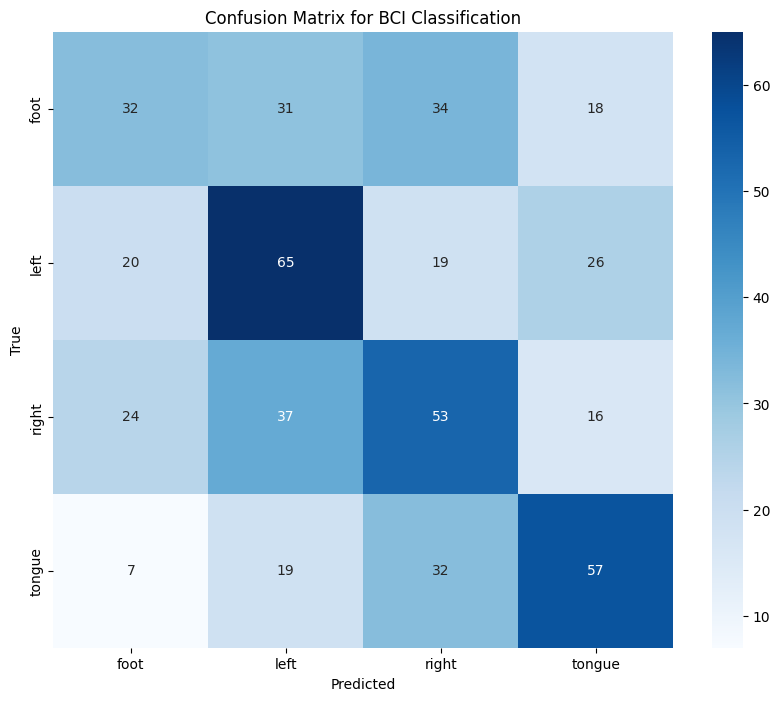

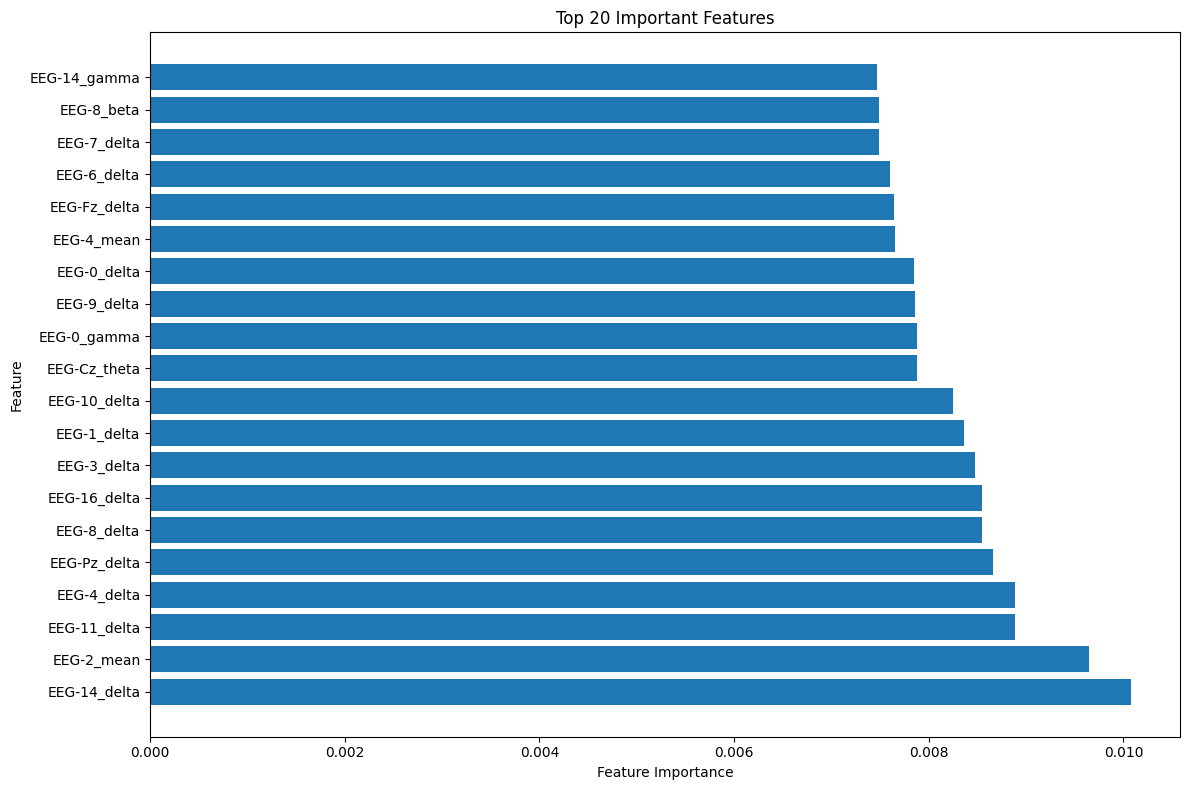

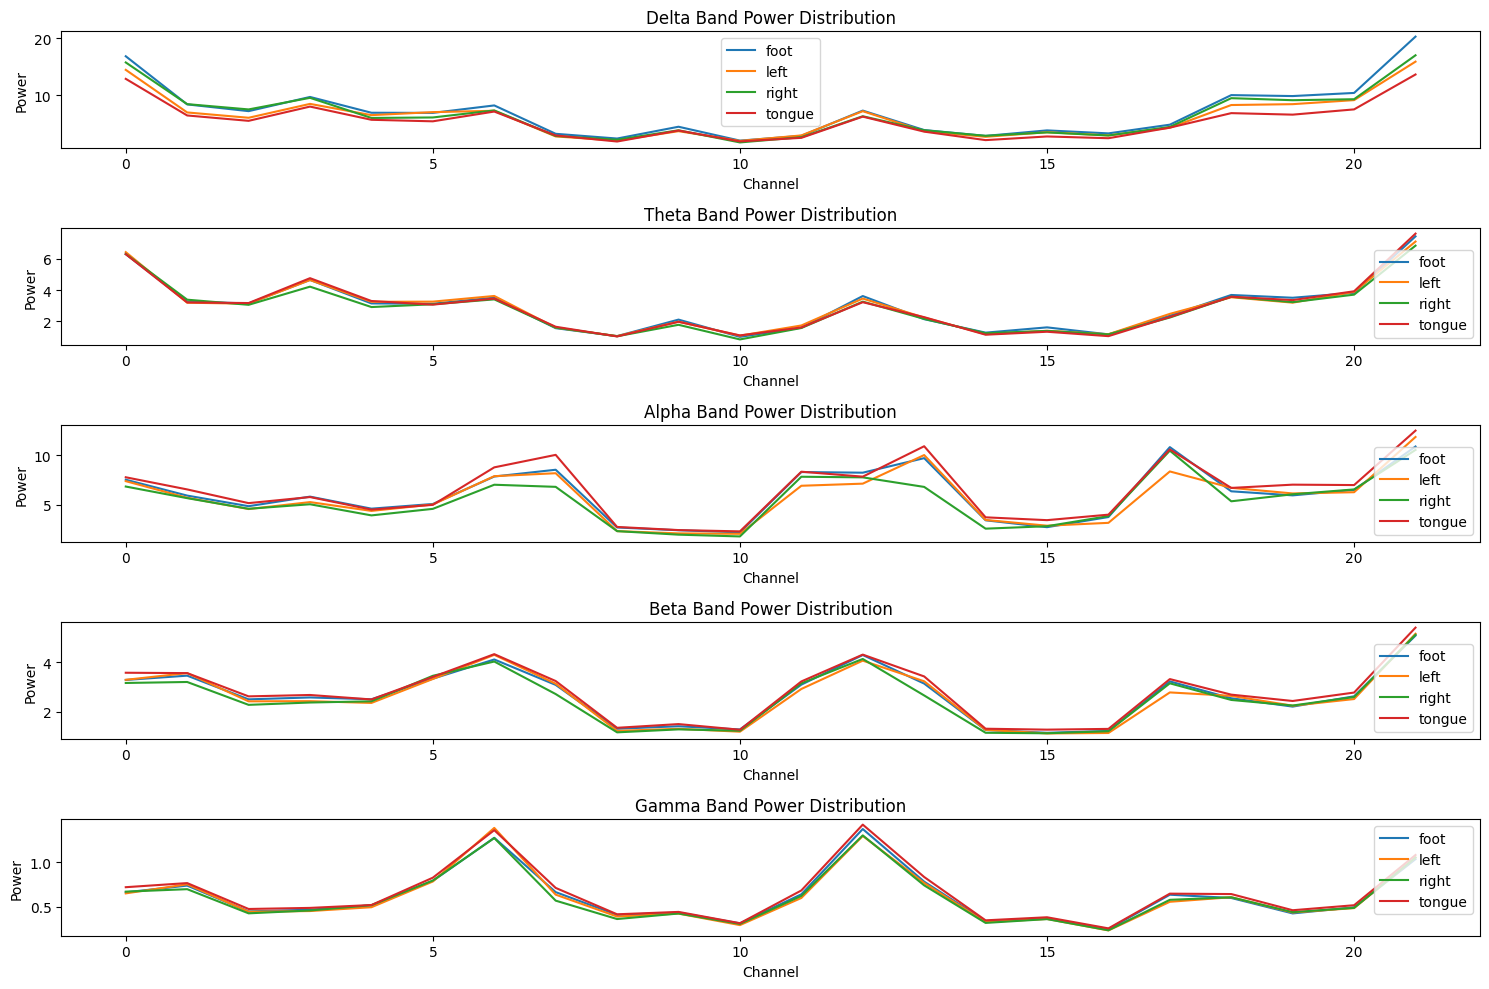

In [ ]:
# ----------- Visualization ----------- #
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix visualization
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
# Modified to use reverse_label_mapping and unique values from y_pred
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[reverse_label_mapping.get(i, str(i)) for i in np.unique(y_pred)],
            yticklabels=[reverse_label_mapping.get(i, str(i)) for i in np.unique(y_pred)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for BCI Classification')
plt.show()

# Feature importance visualization
plt.figure(figsize=(12, 8))
top_n = min(20, len(feature_names))
top_indices = indices[:top_n]
plt.barh(range(top_n), importances[top_indices], align='center')
plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Important Features')
plt.tight_layout()
plt.show()

# Band power distribution by class
plt.figure(figsize=(15, 10))
band_names = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
n_bands = len(band_names)

for i, band_idx in enumerate(range(n_bands)):
    plt.subplot(n_bands, 1, i+1)

    # Calculate mean band power per channel for each class
    band_start_idx = len(eeg_columns) * 2 + band_idx * len(eeg_columns)
    band_data = X[:, band_start_idx:band_start_idx + len(eeg_columns)]

    for label in np.unique(y_int):
        class_band_mean = np.mean(band_data[y_int == label], axis=0)
        # Fix: Use reverse_label_mapping to get the string label for plotting
        plt.plot(class_band_mean, label=reverse_label_mapping.get(label, str(label)))

    plt.title(f"{band_names[i]} Band Power Distribution")
    plt.xlabel("Channel")
    plt.ylabel("Power")
    plt.legend()

plt.tight_layout()
plt.show()